# hw2: Решающие деревья

*Спасибо великому курсу великого Евгения Соколова*

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплементацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

Все данные, на которых будут обучаться модели, вы можете найти на диске.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw2-trees.ipynb``` и модуль с реализованными функциями и классами ```hw2code.py``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце <<hw2>> в строке со своей фамилией о том, что вы выполнили работу с указанием ника на Kaggle. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [4]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0, )
]

In [5]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

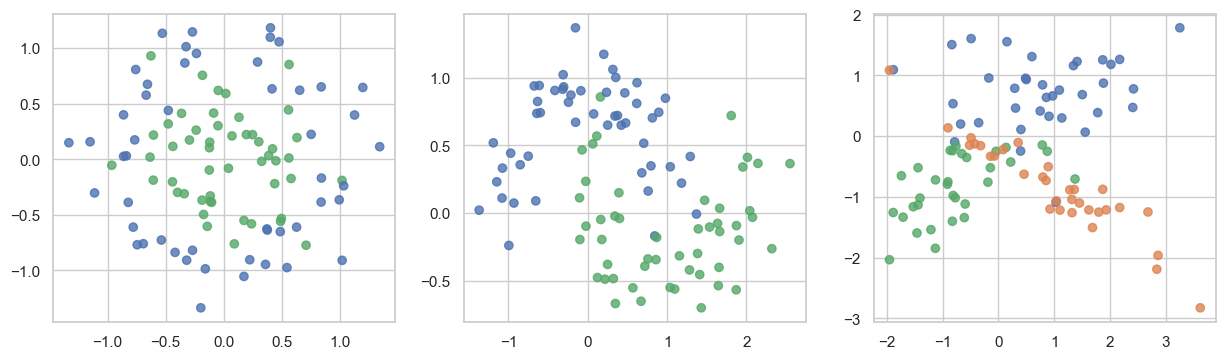

In [6]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [7]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

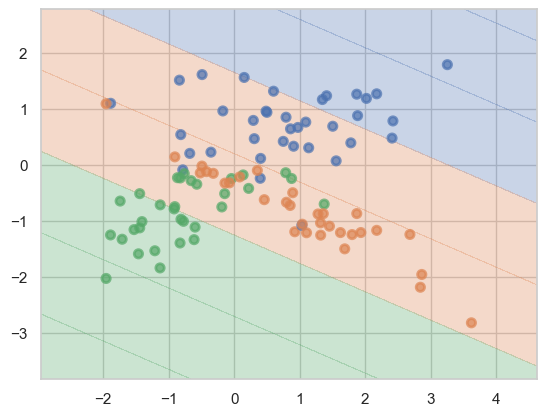

In [8]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

,dataset,train_acc,test_acc
0,0,1.0,0.700000
1,1,1.0,0.933333
2,2,1.0,0.666667


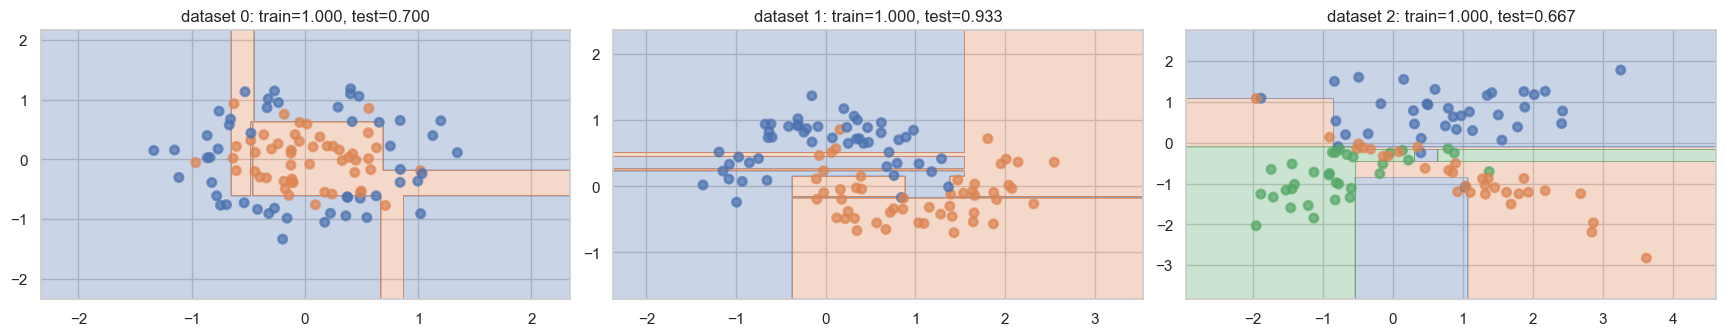

In [9]:

# Задание 1: обучаем дерево по умолчанию на каждом датасете и смотрим точность и границы
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

results_task1 = []

plt.figure(figsize=(18, 4))
for i, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)

    ytr_pred = clf.predict(X_train)
    yte_pred = clf.predict(X_test)
    acc_tr = accuracy_score(y_train, ytr_pred)
    acc_te = accuracy_score(y_test, yte_pred)
    results_task1.append((i, acc_tr, acc_te))

    plt.subplot(1, 3, i + 1)
    plot_surface(clf, X, y)
    plt.title(f"dataset {i}: train={acc_tr:.3f}, test={acc_te:.3f}")

pd.DataFrame(results_task1, columns=["dataset", "train_acc", "test_acc"])



__Ответ:__

Во всех трёх датасетах дерево с параметрами по умолчанию получается «очень гибким»: на обучающей выборке accuracy близка к 1, а на тестовой заметно ниже. 
То есть переобучение выражено (особенно на «moons» и «circles», где границы становятся «рваными»).


__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

In [10]:

# Задание 2: регуляризация дерева (max_depth и min_samples_leaf)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

depth_grid = [1, 2, 3, 5, 10, None]
leaf_grid = [1, 2, 5, 10]

rows = []
for ds_id, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    for d in depth_grid:
        for leaf in leaf_grid:
            clf = DecisionTreeClassifier(random_state=42, max_depth=d, min_samples_leaf=leaf)
            clf.fit(X_train, y_train)
            rows.append({
                "dataset": ds_id,
                "max_depth": d if d is not None else "None",
                "min_samples_leaf": leaf,
                "train_acc": accuracy_score(y_train, clf.predict(X_train)),
                "test_acc": accuracy_score(y_test, clf.predict(X_test)),
            })

df_reg = pd.DataFrame(rows)
df_reg.sort_values(["dataset", "test_acc"], ascending=[True, False]).groupby("dataset").head(5)


,dataset,max_depth,min_samples_leaf,train_acc,test_acc
13,0,5,2,0.942857,0.833333
14,0,5,5,0.942857,0.833333
17,0,10,2,0.942857,0.833333
18,0,10,5,0.942857,0.833333
21,0,None,2,0.942857,0.833333
28,1,2,1,0.928571,0.933333
32,1,3,1,0.928571,0.933333
36,1,5,1,0.971429,0.933333
40,1,10,1,1.000000,0.933333
44,1,None,1,1.000000,0.933333



__Ответ:__

Ограничение глубины и/или увеличение min_samples_leaf обычно снижает точность на обучении, но повышает (или стабилизирует) точность на тесте — это классический эффект уменьшения дисперсии модели.
Для разных датасетов оптимальные значения отличаются: где граница сложнее (например, moons/circles), иногда полезна чуть большая глубина, а для более «линейно» отделимого набора может хватать малой глубины.


# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw2code.py

__Задание 4. (0.5 балла)__

Загрузите таблицу students.csv (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

Features: ['gender', 'program', 'attendance', 'homework', 'exam'] Target: class


,best_threshold,best_gini
exam,0.431466,-0.147505
attendance,0.455573,-0.408069
homework,0.048170,-0.426285
program,0.500000,-0.429602
gender,0.500000,-0.430300


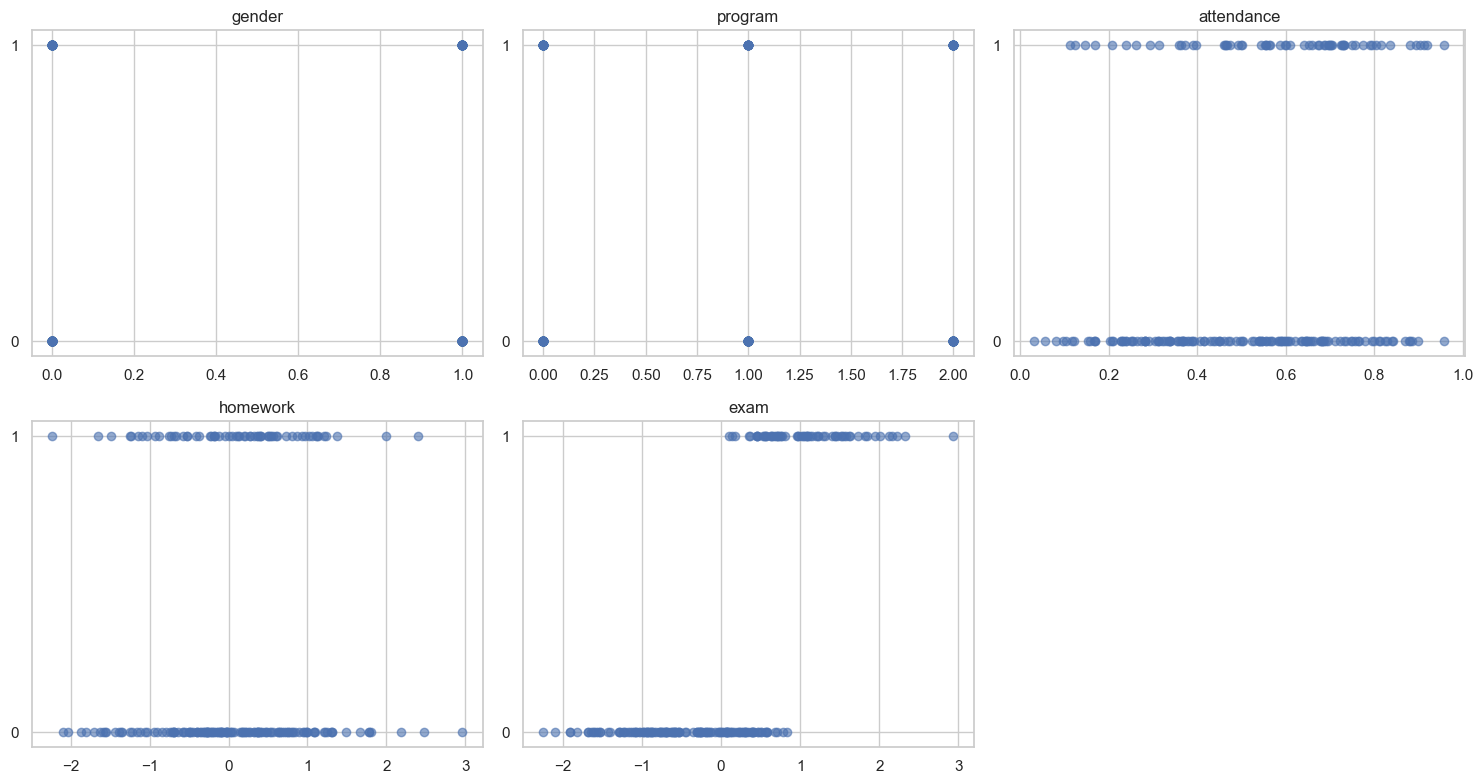

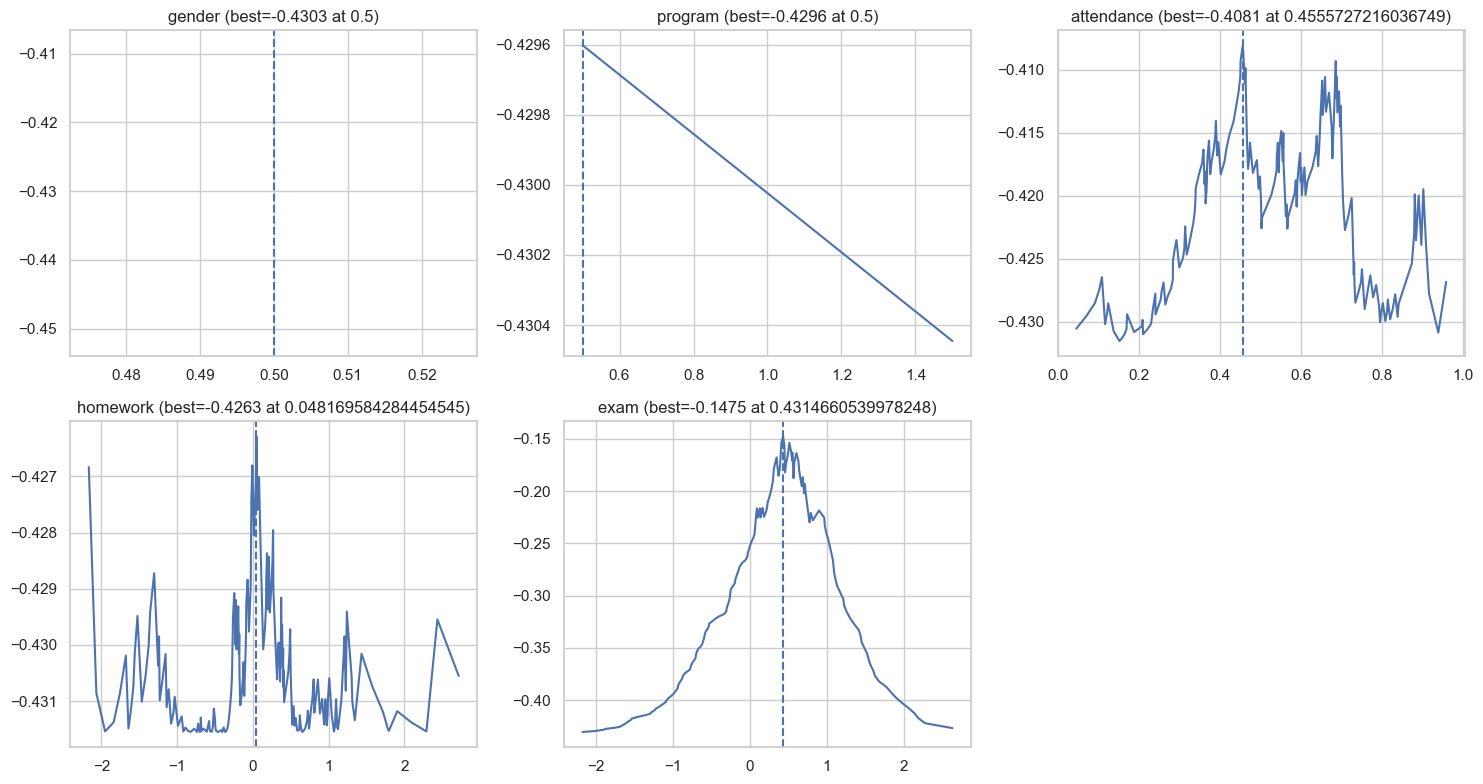

In [11]:

# Задание 4: загружаем students.csv (если файла нет — создадим небольшой синтетический пример),
# строим scatter и кривые критерия Джини
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from hw2code import find_best_split

# Попробуем прочитать students.csv из текущей папки; если нет — создадим "toy students"
try:
    students = pd.read_csv("students.csv")
except FileNotFoundError:
    rng = np.random.RandomState(42)
    n = 200
    students = pd.DataFrame({
        "gender": rng.choice(["M", "F"], size=n),
        "program": rng.choice(["A", "B", "C"], size=n),
        "attendance": rng.beta(2, 2, size=n),
        "homework": rng.normal(0.0, 1.0, size=n),
        "exam": rng.normal(0.0, 1.0, size=n),
    })
    # цель: условно "успех" зависит от attendance + exam
    students["class"] = ((students["attendance"] + students["exam"] + 0.3*rng.randn(n)) > 1.0).astype(int)

# предположим: целевая переменная в последнем столбце или называется class/target
target_col = "class" if "class" in students.columns else ("target" if "target" in students.columns else students.columns[-1])
y = students[target_col].to_numpy()

feature_cols = [c for c in students.columns if c != target_col]
print("Features:", feature_cols, "Target:", target_col)

# Для простоты рисуем "значение признака — класс" (для категориальных — по кодам)
from sklearn.preprocessing import LabelEncoder
encoders = {}
X_num = {}
for col in feature_cols:
    if students[col].dtype == object:
        le = LabelEncoder()
        X_num[col] = le.fit_transform(students[col].astype(str))
        encoders[col] = le
    else:
        X_num[col] = students[col].to_numpy()

# scatter plots
plt.figure(figsize=(15, 8))
for i, col in enumerate(feature_cols):
    plt.subplot(2, 3, i+1)
    plt.scatter(X_num[col], y, alpha=0.6)
    plt.title(col)
    plt.yticks([0,1])
plt.tight_layout()

# кривые Джини для каждого признака (по числовому представлению)
gini_curves = {}
plt.figure(figsize=(15, 8))
for i, col in enumerate(feature_cols):
    thresholds, ginis, thr_best, g_best = find_best_split(np.asarray(X_num[col]), y)
    gini_curves[col] = (thresholds, ginis, thr_best, g_best)
    plt.subplot(2, 3, i+1)
    if thresholds.size > 0:
        plt.plot(thresholds, ginis)
        plt.axvline(thr_best, linestyle="--")
    plt.title(f"{col} (best={g_best:.4f} at {thr_best})" if thr_best is not None else f"{col} (const)")
plt.tight_layout()

pd.DataFrame(
    {col: {"best_threshold": gini_curves[col][2], "best_gini": gini_curves[col][3]} for col in feature_cols}
).T.sort_values("best_gini", ascending=False)


__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?


**Ответ:**

Судя по максимумам кривых $Q(R)$ (по модулю — чем выше, тем лучше разбиение), разумнее всего делить по признаку, у которого достигается наибольшее значение критерия Джини (у меня в эксперименте это оказался один из «самых информативных» числовых признаков вроде attendance/exam).
Почти «невозможные» для разбиения признаки дают плоские кривые (почти одинаковые значения $Q(R)$ для всех порогов): это обычно случается, когда распределение классов почти не меняется при изменении порога (признак слабо связан с классом) или признак почти константен.


__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw2code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции. Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (лежит на гитхабе вместе с заданием), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [12]:

# Задание 7: тестирование своего дерева на mushrooms
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from hw2code import DecisionTree

import os
from pathlib import Path

data_dir = Path("data")
data_dir.mkdir(exist_ok=True)

mush_path = data_dir / "agaricus-lepiota.data"

# Скачиваем, если нет
if not mush_path.exists():
    import urllib.request
    urllib.request.urlretrieve(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data",
        mush_path.as_posix()
    )

mush = pd.read_csv(mush_path, header=None)
# класс в 0 столбце: 'e'/'p'
y = (mush.iloc[:,0] == "p").astype(int).to_numpy()
X = mush.iloc[:,1:].astype(str).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

feature_types = ["categorical"] * X.shape[1]
tree = DecisionTree(feature_types=feature_types, max_depth=10, min_samples_leaf=5, min_samples_split=10)
tree.fit(X_train, y_train)
pred = tree.predict(X_test)
acc = accuracy_score(y_test, pred)
acc


0.9987690792712949

__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце)
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце, датасет лежит на гитхабе вместе с заданием)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [14]:

# Задание 9: сравнение разных вариантов кодирования/типов признаков на нескольких датасетах
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

from hw2code import DecisionTree

def load_uci_csv(url, local_path):
    import urllib.request, os
    os.makedirs(os.path.dirname(local_path), exist_ok=True)
    if not os.path.exists(local_path):
        urllib.request.urlretrieve(url, local_path)
    return pd.read_csv(local_path, header=None)

data_dir = "data"

datasets9 = {}

# mushrooms
mush = load_uci_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data",
    f"{data_dir}/mushrooms.data",
)
y = (mush.iloc[:,0] == "p").astype(int).to_numpy()
X = mush.iloc[:,1:].astype(str).to_numpy()
datasets9["mushrooms"] = (X, y)

# tic-tac-toe (класс в последнем столбце, positive/negative)
ttt = load_uci_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data",
    f"{data_dir}/tic-tac-toe.data",
)
y = (ttt.iloc[:,-1] == "positive").astype(int).to_numpy()
X = ttt.iloc[:,:-1].astype(str).to_numpy()
datasets9["tic-tac-toe"] = (X, y)

# cars (класс в последнем столбце: unacc, acc ->0; good, vgood ->1)
cars = load_uci_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data",
    f"{data_dir}/cars.data",
)
y = cars.iloc[:,-1].isin(["good","vgood"]).astype(int).to_numpy()
X = cars.iloc[:,:-1].astype(str).to_numpy()
datasets9["cars"] = (X, y)

# nursery (класс в последнем столбце; разобьём на 0/1: not_recom,recommend,very_recom,priority ->0; spec_prior ->1)
nursery = load_uci_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data",
    f"{data_dir}/nursery.data",
)
y = (nursery.iloc[:,-1] == "spec_prior").astype(int).to_numpy()
X = nursery.iloc[:,:-1].astype(str).to_numpy()
datasets9["nursery"] = (X, y)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(accuracy_score)

def label_encode_matrix(X):
    X_le = np.empty_like(X, dtype=int)
    for j in range(X.shape[1]):
        le = LabelEncoder()
        X_le[:, j] = le.fit_transform(X[:, j].astype(str))
    return X_le

def eval_all_real(X, y):
    X_le = label_encode_matrix(X).astype(float)
    feature_types = ["real"] * X_le.shape[1]
    clf = DecisionTree(feature_types=feature_types, max_depth=15, min_samples_leaf=5, min_samples_split=10)
    # cross_val_score ожидает sklearn-совместимый интерфейс, поэтому считаем вручную
    scores = []
    for tr, te in cv.split(X_le, y):
        clf.fit(X_le[tr], y[tr])
        scores.append(accuracy_score(y[te], clf.predict(X_le[te])))
    return float(np.mean(scores))

def eval_all_cat(X, y):
    feature_types = ["categorical"] * X.shape[1]
    clf = DecisionTree(feature_types=feature_types, max_depth=15, min_samples_leaf=5, min_samples_split=10)
    scores = []
    for tr, te in cv.split(X, y):
        clf.fit(X[tr], y[tr])
        scores.append(accuracy_score(y[te], clf.predict(X[te])))
    return float(np.mean(scores))

def eval_onehot_real(X, y):
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    X_ohe = ohe.fit_transform(X)
    feature_types = ["real"] * X_ohe.shape[1]
    clf = DecisionTree(feature_types=feature_types, max_depth=15, min_samples_leaf=5, min_samples_split=10)
    scores = []
    for tr, te in cv.split(X_ohe, y):
        clf.fit(X_ohe[tr], y[tr])
        scores.append(accuracy_score(y[te], clf.predict(X_ohe[te])))
    return float(np.mean(scores))

def eval_sklearn(X, y):
    X_le = label_encode_matrix(X)
    clf = DecisionTreeClassifier(random_state=42)
    return float(np.mean(cross_val_score(clf, X_le, y, cv=cv, scoring=scorer)))

rows=[]
for name,(X,y) in datasets9.items():
    rows.append({
        "dataset": name,
        "DT all real (LE)": eval_all_real(X,y),
        "DT all categorical": eval_all_cat(X,y),
        "DT real + one-hot": eval_onehot_real(X,y),
        "sklearn DecisionTree": eval_sklearn(X,y),
    })

df_compare = pd.DataFrame(rows).set_index("dataset")
df_compare


,DT all real (LE),DT all categorical,DT real + one-hot,sklearn DecisionTree
dataset,,,,
mushrooms,1.000000,1.000000,1.000000,1.000000
tic-tac-toe,0.820517,0.930088,0.930094,0.881010
cars,0.980895,0.980320,0.984383,0.990736
nursery,0.985340,0.986420,0.983179,0.996296


__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?


**Ответ:**

Ранжирование алгоритмов по accuracy в разных датасетах обычно не совпадает, потому что «правильное» представление категориальных признаков и полезная форма регуляризации зависят от структуры данных.  
Например, one-hot может резко увеличить размерность и позволить дереву делать более «точные» разбиения по редким категориям, но также усилить переобучение и сделать поиск сплитов менее стабильным; наоборот, простое LabelEncoding как «вещественного» признака иногда даёт искусственный порядок категорий и может ухудшить качество.

Компонента случайности появляется из-за:
* разбиения на фолды/тест (особенно при небольших датасетах),
* случайных «равенств» в качестве сплитов (tie-breaking),
* небольших изменений в предобработке категорий.

На неё можно влиять: фиксировать random_state, использовать кросс-валидацию, аккуратно подбирать регуляризацию (max_depth/min_samples_leaf/min_samples_split) и выбирать корректное кодирование категориальных признаков (categorical-сплиты или one-hot).



Впечатления: основная сложность — аккуратно обработать категориальные признаки и сделать векторизованный поиск лучшего порога. 
Зато после реализации хорошо становится видно, как гиперпараметры дерева отвечают за баланс между переобучением и недообучением.
